In [1]:
using Oceananigans
using NCDatasets
using CairoMakie
using Printf

In [2]:
] status

Status `~/code/Irvinanigans.jl/Project.toml`
⌃ [13f3f980] CairoMakie v0.11.10
  [7073ff75] IJulia v1.24.2
⌃ [85f8d34a] NCDatasets v0.14.3
  [9e8cae18] Oceananigans v0.91.0
⌃ [91a5bcdd] Plots v1.40.1
Info Packages marked with ⌃ have new versions available and may be upgradable.


In [4]:
Ri = 0.1;

In [4]:
Nx, Nz = 64, 64
H = 10
L = 10

grid = RectilinearGrid(
    size=(Nx, Nz),
    x=(-H/2, H/2),
    z=(-L/2, L/2),
    topology=(Periodic, Flat, Bounded)
)

n_particles=100;

x₀ = (rand(100) .- 0.5) .* 10;

y₀ = zeros(n_particles);

z₀ = zeros(n_particles);

lagrangian_particles = LagrangianParticles(x=x₀, y=y₀, z=z₀)

@show n_particles;

n_particles = 100


In [5]:
shear_flow(x, z, t) = tanh(z)

stratification(x, z, t, p) = p.h * p.Ri * tanh(z / p.h)

U = BackgroundField(shear_flow)

B = BackgroundField(stratification, parameters=(Ri=Ri, h=1.25));

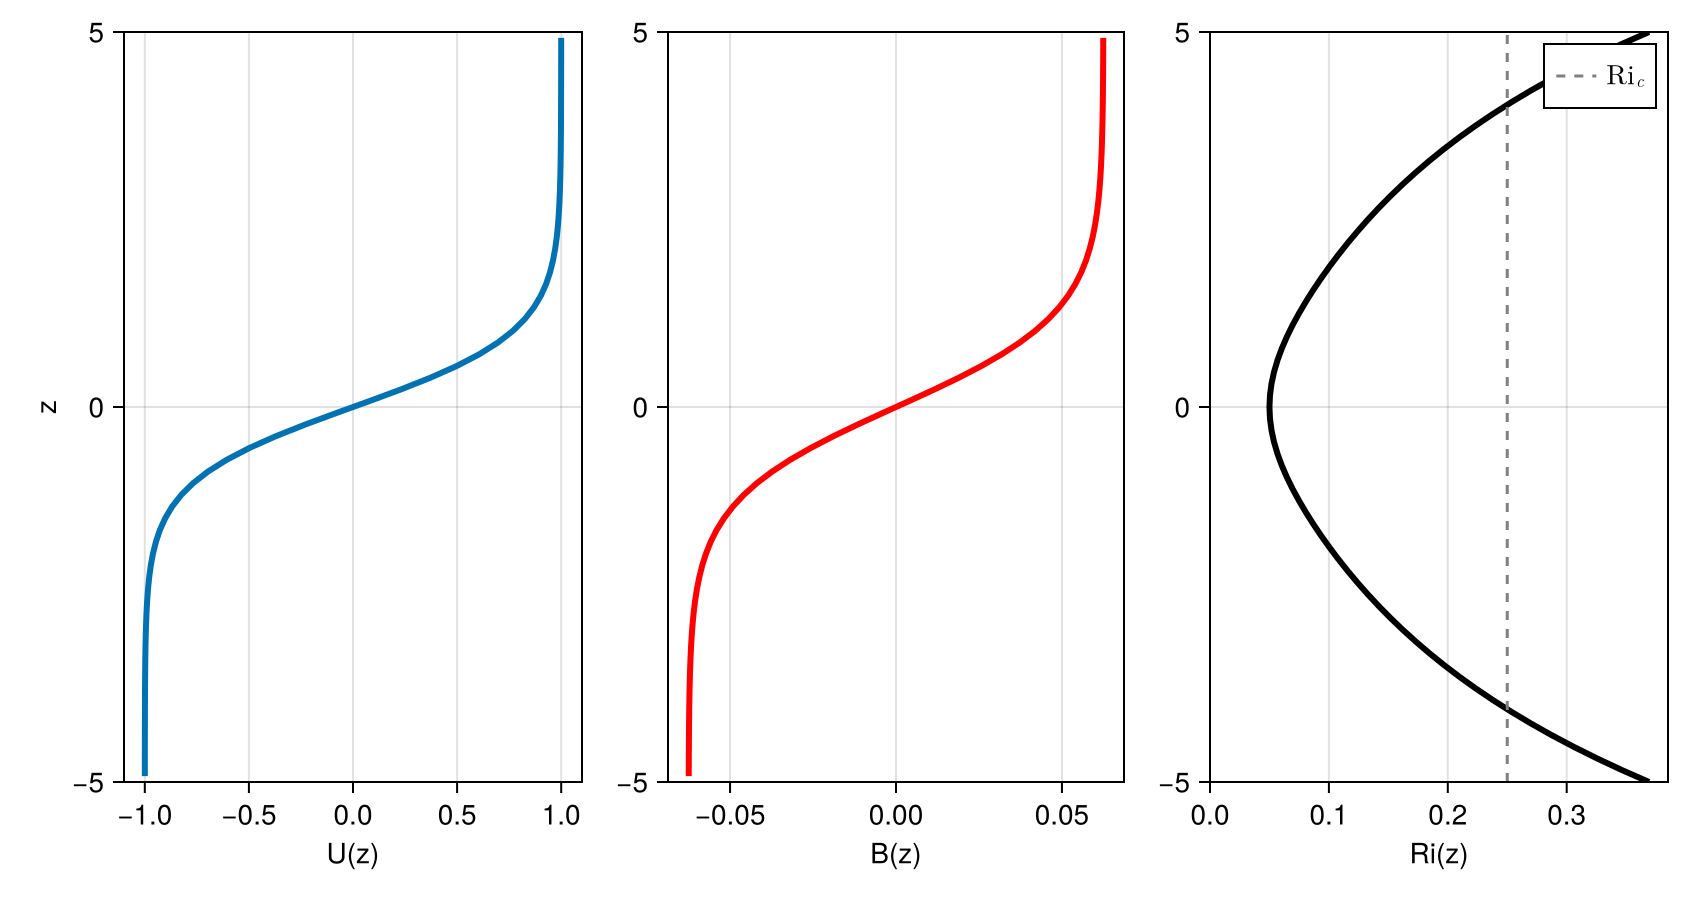

In [6]:
zF = znodes(grid, Face())
zC = znodes(grid, Center())

Ri, h = B.parameters

fig = Figure(size = (850, 450))

ax = Axis(fig[1, 1], xlabel = "U(z)", ylabel = "z", limits=((nothing, nothing), (-5, 5)))
lines!(ax, shear_flow.(0, zC, 0), zC; linewidth = 3)

ax = Axis(fig[1, 2], xlabel = "B(z)", limits=((nothing, nothing), (-5, 5)))
lines!(ax, [stratification(0, z, 0, (Ri=Ri, h=h)) for z in zC], zC; linewidth = 3, color = :red)

ax = Axis(fig[1, 3], xlabel = "Ri(z)", limits=((0, nothing), (-5, 5)))
lines!(
    ax, [Ri * sech(z / h)^2 / sech(z)^2 for z in zF], zF;
    linewidth = 3, color = :black,
) # Ri(z)= ∂_z B / (∂_z U)²; derivatives computed by hand
vlines!(ax, [0.25], linestyle=:dash, color=:gray, label=L"Ri$_{c}$") # Critical Richardson number
axislegend(ax)

fig

In [7]:
model = NonhydrostaticModel(timestepper = :RungeKutta3,
                              advection = UpwindBiasedFifthOrder(),
                                   grid = grid,
                              particles = lagrangian_particles,
                               coriolis = nothing,
                      background_fields = (u=U, b=B),
                                closure = ScalarDiffusivity(ν=5e-5, κ=5e-5),
                               buoyancy = BuoyancyTracer(),
                                tracers = :b)

NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── grid: 64×1×64 RectilinearGrid{Float64, Periodic, Flat, Bounded} on CPU with 3×0×3 halo
├── timestepper: RungeKutta3TimeStepper
├── advection scheme: Upwind Biased reconstruction order 5
├── tracers: b
├── closure: ScalarDiffusivity{ExplicitTimeDiscretization}(ν=5.0e-5, κ=(b=5.0e-5,))
├── buoyancy: BuoyancyTracer with ĝ = NegativeZDirection()
├── coriolis: Nothing
└── particles: 100 LagrangianParticles with eltype Particle and properties (:x, :y, :z)

In [8]:
Δt = 0.2
simulation = Simulation(model, Δt=Δt, stop_iteration=1000, verbose=true)

Simulation of NonhydrostaticModel{CPU, RectilinearGrid}(time = 0 seconds, iteration = 0)
├── Next time step: 200 ms
├── Elapsed wall time: 0 seconds
├── Wall time per iteration: NaN days
├── Stop time: Inf days
├── Stop iteration : 1000.0
├── Wall time limit: Inf
├── Callbacks: OrderedDict with 4 entries:
│   ├── stop_time_exceeded => Callback of stop_time_exceeded on IterationInterval(1)
│   ├── stop_iteration_exceeded => Callback of stop_iteration_exceeded on IterationInterval(1)
│   ├── wall_time_limit_exceeded => Callback of wall_time_limit_exceeded on IterationInterval(1)
│   └── nan_checker => Callback of NaNChecker for u on IterationInterval(100)
├── Output writers: OrderedDict with no entries
└── Diagnostics: OrderedDict with no entries

In [9]:
@info "Setting initial conditions"

using Random, Statistics

u, v, w = model.velocities
b = model.tracers.b
xb, yb, zb = nodes(b)
B = Field(b + model.background_fields.tracers.b)

TKE = Field(Average(1/2 * (u^2 + w^2)))

noise(x, z) = 1.e-4*randn()
set!(model, u=noise, w=noise, b=noise)

[ Info: Setting initial conditions


In [10]:
global_attributes = Dict("Ri" => Ri)

simulation.output_writers[:state] = NetCDFOutputWriter(
    model, (u=u, w=w, b=b, B=B,),
    schedule = TimeInterval(3.0),
    filename =  string("../data/raw_output/shear_instability_state_Ri=",Ri,".nc"),
    global_attributes = global_attributes,
    overwrite_existing = true
)

simulation.output_writers[:averages] = NetCDFOutputWriter(
    model, (TKE=TKE,),
    schedule = TimeInterval(1.0),
    filename = string("../data/processed_output/shear_instability_TKE_Ri=",Ri,".nc"),
    global_attributes = global_attributes,
    overwrite_existing = true
)

simulation.output_writers[:particles] = NetCDFOutputWriter(
    model, model.particles,
    schedule=TimeInterval(0.5),
    filename="../data/lagrangian_particles.nc",
)

simulation.output_writers

OrderedCollections.OrderedDict{Symbol, Oceananigans.AbstractOutputWriter} with 3 entries:
  :state     => NetCDFOutputWriter scheduled on TimeInterval(3 seconds):…
  :averages  => NetCDFOutputWriter scheduled on TimeInterval(1 second):…
  :particles => NetCDFOutputWriter scheduled on TimeInterval(500 ms):…

In [11]:
@info "*** Running a simulation of Kelvin-Helmholtz (stratified shear) instability..."
run!(simulation)

[ Info: *** Running a simulation of Kelvin-Helmholtz (stratified shear) instability...
[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (3.999 seconds)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (3.528 seconds).
[ Info: Simulation is stopping after running for 24.322 seconds.
[ Info: Model iteration 1000 equals or exceeds stop iteration 1000.


In [12]:
ds = NCDataset(simulation.output_writers[:particles].filepath, "r")
show(ds)
close(ds)

Dataset: ./../data/lagrangian_particles.nc
Group: /

Dimensions
   particle_id = 100
   time = 334

Variables
  particle_id   (100)
    Datatype:    Float64 (Float64)
    Dimensions:  particle_id
    Attributes:
     long_name            = Particle ID

  time   (334)
    Datatype:    Float64 (Float64)
    Dimensions:  time
    Attributes:
     units                = seconds
     long_name            = Time

  x   (100 × 334)
    Datatype:    Float64 (Float64)
    Dimensions:  particle_id × time

  y   (100 × 334)
    Datatype:    Float64 (Float64)
    Dimensions:  particle_id × time

  z   (100 × 334)
    Datatype:    Float64 (Float64)
    Dimensions:  particle_id × time

Global attributes
  interval             = 0.5
  Oceananigans         = This file was generated using Oceananigans v0.91.0
  Julia                = This file was generated using Julia Version 1.10.2
Commit bd47eca2c8a (2024-03-01 10:14 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: mac

closed Dataset

In [6]:
ds = NCDataset(simulation.output_writers[:particles].filepath, "r");

LoadError: UndefVarError: `simulation` not defined

In [14]:
ds["x"]

x (100 × 334)
  Datatype:    Float64 (Float64)
  Dimensions:  particle_id × time


In [15]:
ds["time"][:]

334-element Vector{Float64}:
   0.0
   0.5
   1.0
   1.5000000000000002
   2.0
   2.5
   3.0
   3.5
   4.0
   4.5
   5.0
   5.5
   6.0
   ⋮
 161.0
 161.5
 162.0
 162.5
 163.0
 163.5
 164.0
 164.5
 165.0
 165.5
 166.0
 166.5

In [16]:
for t in ds["time"][:]
    print(t, ", ")
end;

0.0, 0.5, 1.0, 1.5000000000000002, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 5.5, 6.0, 6.5, 7.0, 7.5, 8.0, 8.500000000000002, 9.0, 9.500000000000002, 10.0, 10.500000000000002, 11.0, 11.500000000000002, 12.0, 12.500000000000002, 13.0, 13.500000000000002, 14.0, 14.500000000000002, 15.0, 15.500000000000002, 16.0, 16.5, 17.0, 17.5, 18.0, 18.5, 19.0, 19.5, 20.0, 20.5, 21.0, 21.5, 22.0, 22.5, 23.0, 23.5, 24.0, 24.5, 25.0, 25.5, 26.0, 26.5, 27.0, 27.5, 28.0, 28.5, 29.0, 29.5, 30.0, 30.5, 31.0, 31.5, 32.0, 32.5, 33.0, 33.5, 34.0, 34.5, 35.0, 35.5, 36.0, 36.5, 37.0, 37.5, 38.0, 38.5, 39.0, 39.5, 40.0, 40.5, 41.0, 41.5, 42.0, 42.5, 43.0, 43.5, 44.0, 44.5, 45.0, 45.5, 46.0, 46.5, 47.0, 47.5, 48.0, 48.5, 49.0, 49.5, 50.0, 50.5, 51.0, 51.5, 52.0, 52.5, 53.0, 53.5, 54.0, 54.5, 55.0, 55.5, 56.0, 56.5, 57.0, 57.5, 58.0, 58.5, 59.0, 59.5, 60.0, 60.5, 61.0, 61.5, 62.0, 62.5, 63.0, 63.5, 64.0, 64.5, 65.0, 65.5, 66.0, 66.5, 67.0, 67.5, 68.0, 68.5, 69.0, 69.5, 70.0, 70.5, 71.0, 71.5, 72.0, 72.5, 73.0, 73.5, 74.0,

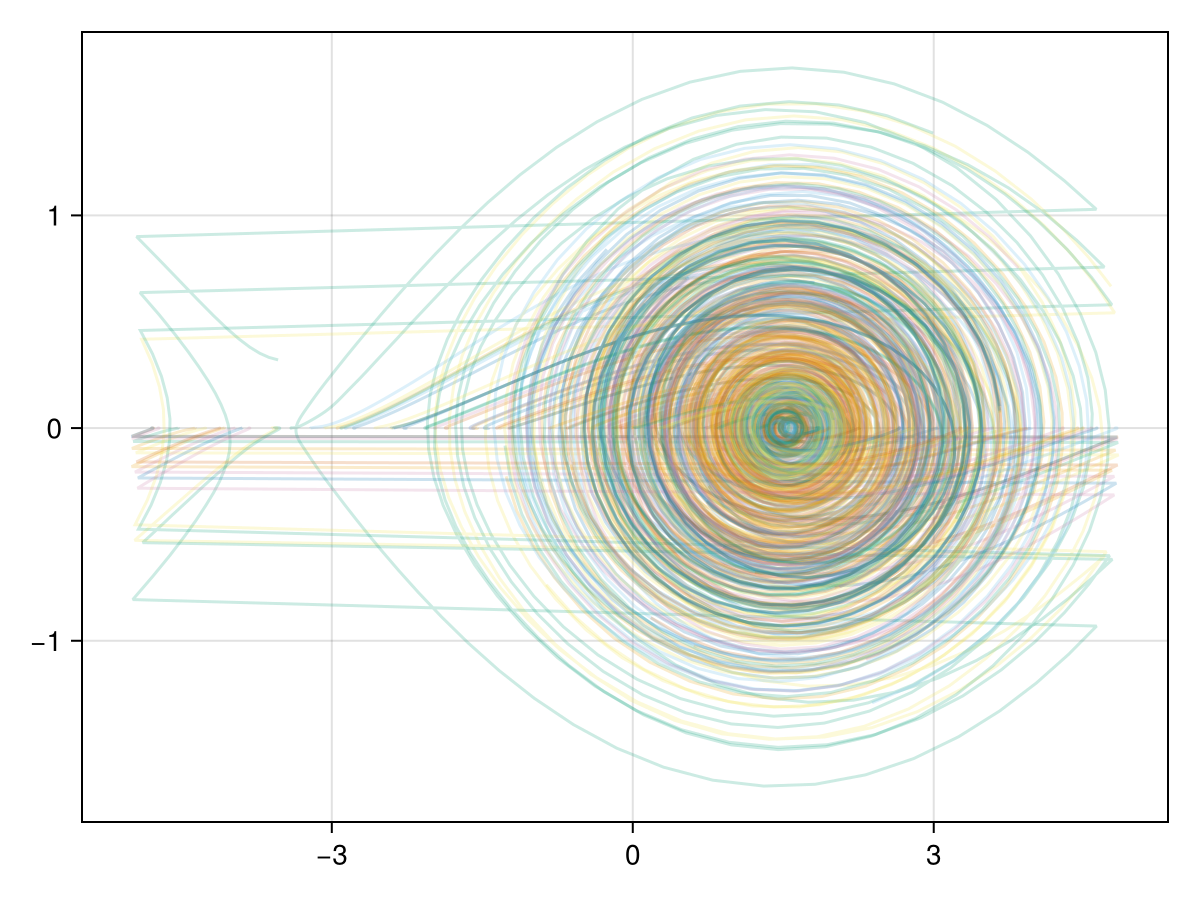

In [17]:
f = Figure()
ax = Axis(f[1,1])
for (p, pid) in enumerate(ds["particle_id"])
    lines!(ax, ds["x"][p,:], ds["z"][p,:], alpha=0.2)
end
save("particle_spagetti.png", f)
f

In [18]:
ds["z"][:,end]

100-element Vector{Float64}:
 -0.06964493790086884
 -0.01024749712327406
 -0.001399108563023548
  0.030530032137234105
  0.04352292977919577
 -0.0015108433645283899
 -0.27626675775790804
  0.8405123442499641
 -1.0236472181248777
 -0.026176893620386214
 -0.0015983938408361603
  0.30012553917927026
 -0.007436274288499859
  ⋮
 -0.7468390496080851
 -0.004273013789668082
  0.04309491743913609
  0.08231817233877883
  0.17809012574139196
 -0.10240421215137735
  0.659677324516568
 -0.015182106773808775
  0.15869188796102224
 -0.07977579938805142
  0.1031912075183537
 -0.3974488390700864

In [5]:
ds["time"][end]

LoadError: UndefVarError: `ds` not defined

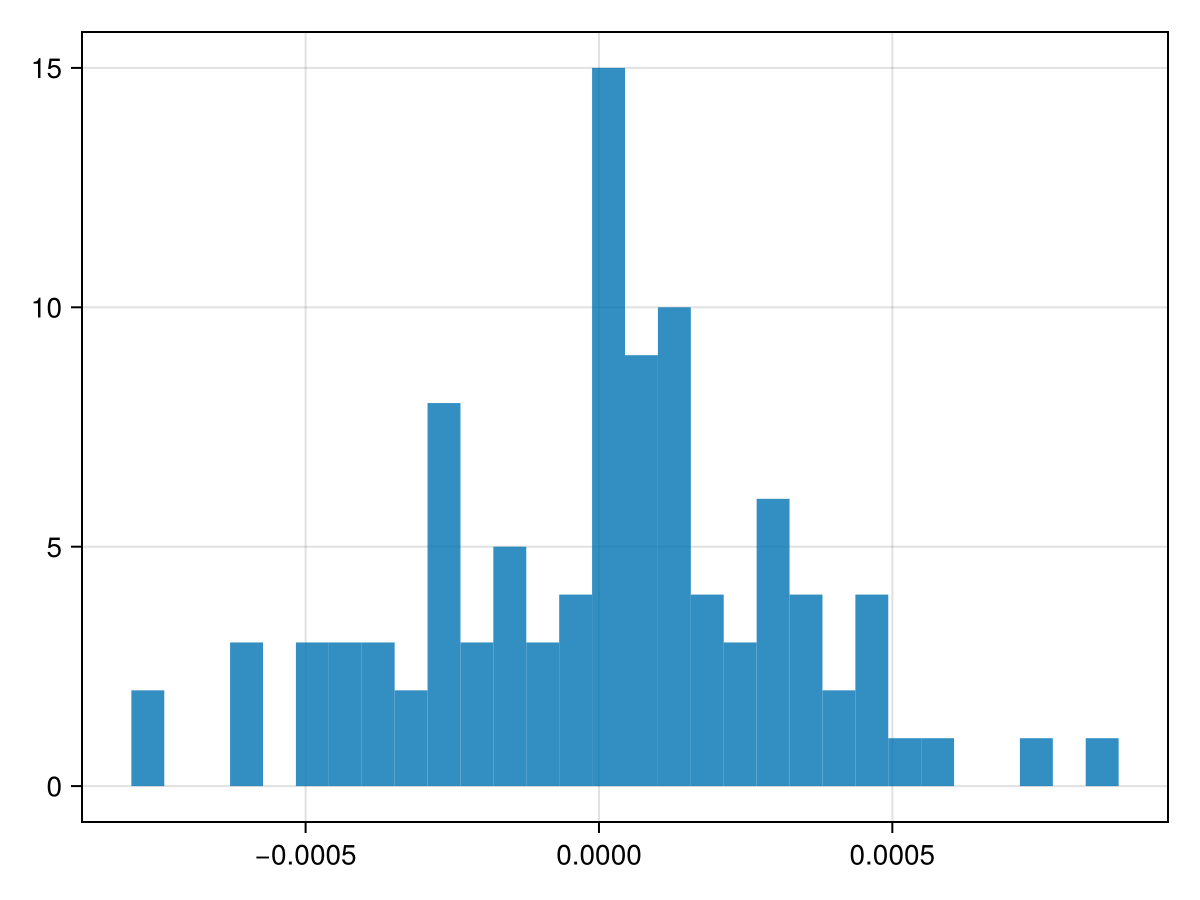

In [20]:
hist(ds["z"][:,end], bins=30)

In [1]:
for ds["z"] in ds[:,end]
    stdm(ds["z"], mean; corrected::Bool=true)
end

LoadError: syntax: invalid keyword argument name "corrected::Bool" around In[1]:2

In [21]:
close(ds)

closed Dataset

In [22]:
ds = NCDataset(simulation.output_writers[:state].filepath, "r")
show(ds)
close(ds)

Dataset: ./../data/raw_output/shear_instability_state_Ri=0.05.nc
Group: /

Dimensions
   zC = 64
   zF = 65
   xC = 64
   yF = 1
   xF = 64
   yC = 1
   time = 56

Variables
  zC   (64)
    Datatype:    Float64 (Float64)
    Dimensions:  zC
    Attributes:
     units                = m
     long_name            = Locations of the cell centers in the z-direction.

  zF   (65)
    Datatype:    Float64 (Float64)
    Dimensions:  zF
    Attributes:
     units                = m
     long_name            = Locations of the cell faces in the z-direction.

  xC   (64)
    Datatype:    Float64 (Float64)
    Dimensions:  xC
    Attributes:
     units                = m
     long_name            = Locations of the cell centers in the x-direction.

  yF   (1)
    Datatype:    Float64 (Float64)
    Dimensions:  yF
    Attributes:
     units                = m
     long_name            = Locations of the cell faces in the y-direction.

  xF   (64)
    Datatype:    Float64 (Float64)
    Dimensions: 

closed Dataset

In [23]:
@info "Making a neat movie of stratified shear flow..."

ds = NCDataset(simulation.output_writers[:state].filepath, "r")

times = ds["time"][:]
t_final = times[end]

n = Observable(1)

Bₙ = @lift ds["B"][:, 1, :, $n]

fig = Figure(size=(800, 600))

kwargs = (xlabel="x [m]", ylabel="z [m]", limits = ((xb[1], xb[end]), (-3, 3)), aspect=1,)

title = @lift @sprintf("buoyancy [m/s²] at t = %.2f", times[$n])

ax_B = Axis(fig[1, 1]; title = title, kwargs...)

B_lims = (-maximum(abs, ds["B"][:, 1, :, :]), maximum(abs, ds["B"][:, 1, :, :]))

hm_B = heatmap!(ax_B, xb, zb, Bₙ; colorrange = B_lims, colormap = :balance)
Colorbar(fig[1, 2], hm_B)

frames = 1:length(times)

record(fig, "../animations/shear_instability_movie.mp4", frames, framerate=8) do i
    n[] = i
end

close(ds)

[ Info: Making a neat movie of stratified shear flow...


closed Dataset

[ Info: Plotting some snapshots of the simulation at difference times...


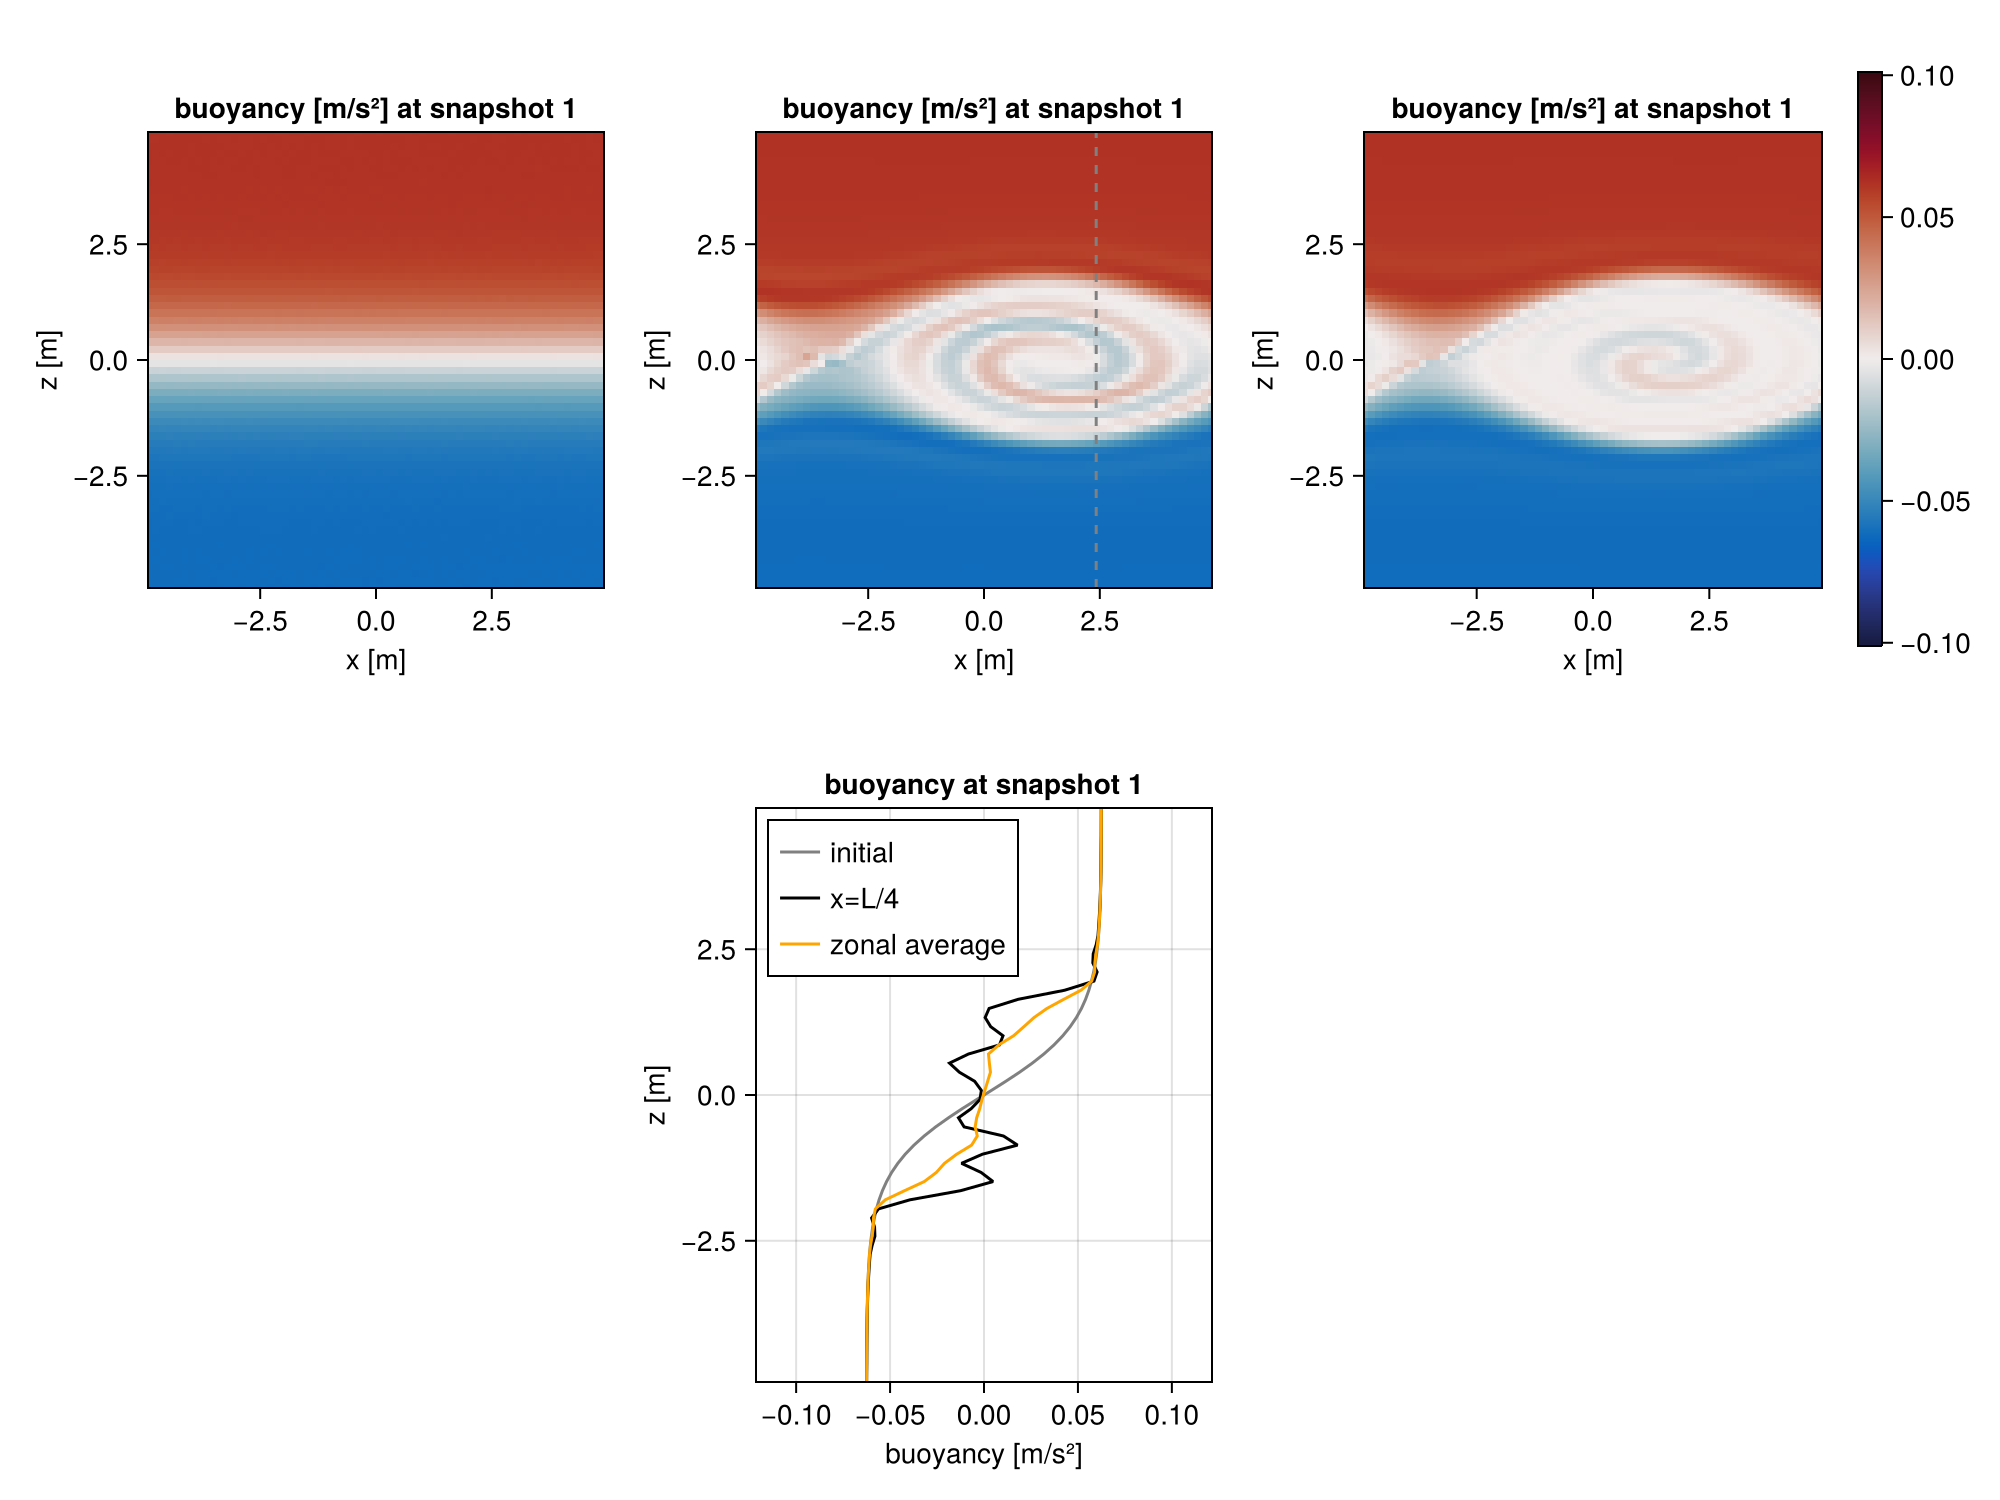

In [24]:
@info "Plotting some snapshots of the simulation at difference times..."

ds = NCDataset(simulation.output_writers[:state].filepath, "r")

fig = Figure(size=(1000, 750))
t = 1
kwargs = (xlabel="x [m]", ylabel="z [m]", limits = ((xb[1], xb[end]), (zb[1], zb[end])), aspect=1,)
ax_B = Axis(fig[1, 1]; title = string("buoyancy [m/s²] at snapshot ",t), kwargs...)
hm_B = heatmap!(ax_B, xb, zb, ds["B"][:,1,:,t]; colorrange = B_lims, colormap = :balance)

n = 40
ax_B = Axis(fig[1, 2]; title = string("buoyancy [m/s²] at snapshot ",t), kwargs...)
hm_B = heatmap!(ax_B, xb, zb, ds["B"][:,1,:,n]; colorrange = B_lims, colormap = :balance)
i = Nx÷2+Nx÷4
vlines!(ax_B, ds["xC"][i], linestyle=:dash, color=:gray)

n_end = length(ds["B"]["time"])
ax_B = Axis(fig[1, 3]; title = string("buoyancy [m/s²] at snapshot ",t), kwargs...)
hm_B = heatmap!(ax_B, xb, zb, ds["B"][:,1,:,n_end]; colorrange = B_lims, colormap = :balance)

ax_B = Axis(fig[2, 2]; title = string("buoyancy at snapshot ",t), xlabel="buoyancy [m/s²]", ylabel="z [m]", limits=(1.2.*B_lims, (zb[1], zb[end])))
l_B = lines!(ax_B, mean(ds["B"][:,1,:,1], dims=(1))[1,:], zb, color=:gray, label="initial")
l_B = lines!(ax_B, ds["B"][i,1,:,n], zb, label="x=L/4", color=:black)

Colorbar(fig[1, 4], hm_B)
leg = axislegend(ax_B, position=:lt)
save("../figures/shear_instability_snapshots.png", fig)

l_B = lines!(ax_B, mean(ds["B"][:,1,:,n], dims=(1))[1,:], zb, label="zonal average", color=:orange)
delete!(leg)
axislegend(ax_B, position=:lt)
save("../figures/shear_instability_snapshots_mean.png", fig)

close(ds)

fig